In [1]:

# Reads the Hagrid static gesture dataset saved as a compressed npz file
import numpy as np
import pandas as pd

def load_hagrid_saved_npz(npz_path: str) -> pd.DataFrame:
    npz = np.load(npz_path, allow_pickle=True)
    arr = np.array(npz[npz.files[0]])  # use first array (e.g. 'arr_0' if unnamed)
    if arr.ndim != 2 or arr.shape[1] != 64:
        raise ValueError(f"Expected shape (N,64), got {arr.shape}")
    labels = arr[:, 0]
    X = arr[:, 1:].astype(float)  # 63 feature columns

    cols = []
    for i in range(21):
        cols += [f"x{i}", f"y{i}", f"z{i}"]

    df = pd.DataFrame(X, columns=cols)
    df.insert(0, "label", labels)
    return df

# Usage
Hagrid = load_hagrid_saved_npz("output/compressed/hagrid_static_gestures.npz")
Hagrid.head() # shows the first few rows
Hagrid.groupby("label").size() # shows counts per label

label
call              26480
dislike           25602
fist              25327
four              27754
like              25692
mute              25672
ok                26756
one               26879
palm              27580
peace             25525
peace_inverted    24353
rock              25978
stop               2647
dtype: int64

In [ ]:
def add_empty_rows(df: pd.DataFrame, n: int = 5, label_value=None, feature_fill=np.nan) -> pd.DataFrame:
    """
    Return a new DataFrame with `n` appended rows:
    - first column is treated as the label and set to `label_value` (e.g. None)
    - remaining columns are filled with `feature_fill` (default NaN)
    """
    if n <= 0:
        return df.copy()

    df_copy = df.copy()
    cols = df_copy.columns.tolist()
    label_col = cols[0]
    feature_cols = cols[1:]

    # Ensure label column can hold None
    df_copy[label_col] = df_copy[label_col].astype(object)

    data = {label_col: [label_value] * n}
    for c in feature_cols:
        data[c] = [feature_fill] * n

    empty_df = pd.DataFrame(data, columns=cols)
    return pd.concat([df_copy, empty_df], ignore_index=True)


In [2]:
#Hagrid = add_empty_rows(Hagrid, n =20000, label_value="None")
# shuffle the DataFrame rows
shuffled_df = Hagrid.sample(frac=1).reset_index(drop=True)
print(shuffled_df.groupby("label").size())
shuffled_df.head()

label
call              26480
dislike           25602
fist              25327
four              27754
like              25692
mute              25672
ok                26756
one               26879
palm              27580
peace             25525
peace_inverted    24353
rock              25978
stop               2647
dtype: int64


,label,x0,y0,z0,x1,y1,z1,x2,y2,z2,...,z17,x18,y18,z18,x19,y19,z19,x20,y20,z20
0,dislike,0.209966,0.514147,-7.562408e-07,0.328627,0.642486,-0.032545,0.542138,0.743155,-0.045702,...,-0.099467,0.632987,0.343123,-0.148653,0.532794,0.393676,-0.111386,0.510914,0.353640,-0.073410
1,peace_inverted,0.418052,0.862029,9.895417e-07,0.352706,0.720397,0.082164,0.376049,0.633285,0.084689,...,-0.125373,0.603925,0.604949,-0.076253,0.584667,0.634546,-0.008607,0.565303,0.658540,0.041936
2,mute,0.305695,0.549786,2.065931e-07,0.336316,0.498040,0.009970,0.367957,0.440825,-0.000451,...,-0.068257,0.439747,0.470925,-0.079582,0.444165,0.512650,-0.067940,0.436720,0.536828,-0.053728
3,one,0.458516,0.939352,2.350594e-07,0.487667,0.903585,-0.111180,0.479639,0.817207,-0.156643,...,-0.030632,0.293374,0.690491,-0.097841,0.309334,0.741128,-0.090645,0.340043,0.760240,-0.064214
4,one,0.592245,0.580337,-6.678420e-08,0.550774,0.554164,-0.014042,0.521248,0.491056,-0.020702,...,-0.029956,0.634805,0.424944,-0.049836,0.620853,0.462763,-0.036400,0.619636,0.486921,-0.019699


In [3]:
# Check registered labels
registered_labels = shuffled_df["label"].unique()
print(F"Registered labels: {registered_labels}")


Registered labels: ['dislike' 'peace_inverted' 'mute' 'one' 'four' 'call' 'palm' 'rock'
 'fist' 'like' 'peace' 'ok' 'stop']


In [4]:
"""
Prepare data for training:
-Remove rows with label "None"
-Normalize features to [0,1]
-Encode labels
-Split into train and test sets
"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf

# Filter out rows where label is "None"
mask = shuffled_df['label'] != "None"
filtered_df = shuffled_df[mask]

labels = filtered_df['label']
features = filtered_df.iloc[:, 1:].astype(float)
print("Features shape after removing 'None':", features.shape)

# Normalize features to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(features.values)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print(encoder.classes_)


Features shape after removing 'None': (316245, 63)
Train shape: (252996, 63) (252996,)
Test shape: (63249, 63) (63249,)
['call' 'dislike' 'fist' 'four' 'like' 'mute' 'ok' 'one' 'palm' 'peace'
 'peace_inverted' 'rock' 'stop']


In [5]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(63,)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(len(encoder.classes_), activation="softmax")
])
# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)


Epoch 1/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8525 - loss: 0.4496 - val_accuracy: 0.9473 - val_loss: 0.1856
Epoch 2/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9590 - loss: 0.1509 - val_accuracy: 0.9620 - val_loss: 0.1321
Epoch 3/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9703 - loss: 0.1141 - val_accuracy: 0.9759 - val_loss: 0.0990
Epoch 4/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9751 - loss: 0.0963 - val_accuracy: 0.9777 - val_loss: 0.0898
Epoch 5/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9781 - loss: 0.0856 - val_accuracy: 0.9775 - val_loss: 0.0919
Epoch 6/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9794 - loss: 0.0800 - val_accuracy: 0.9837 - val_loss: 0.0686
Epoch 7/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9801 - loss: 0.0759 - val_accuracy: 0.9679 - val_loss: 0.1077
Epoch 8/50
7907/7907 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9811 - loss: 0

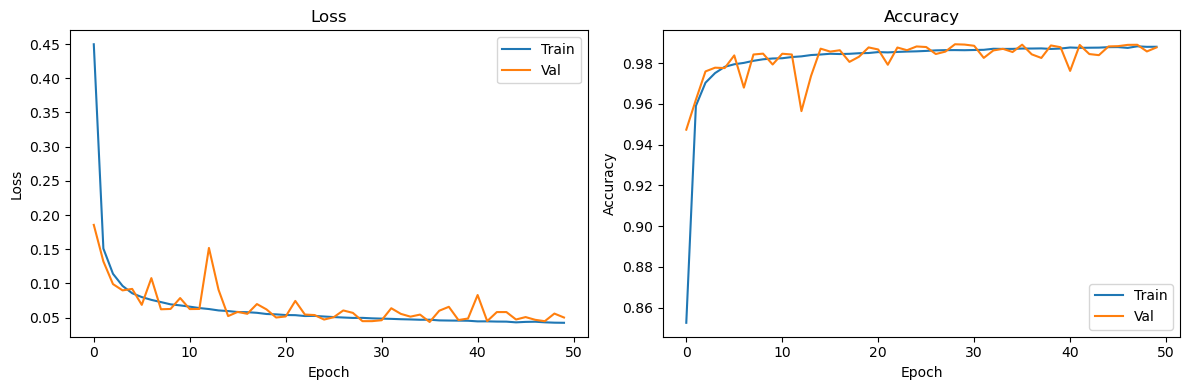

In [6]:
# Plot training history to see how loss and accuracy evolved
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend(["Train", "Val"])

# Accuracy
axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(["Train", "Val"])

plt.tight_layout()
plt.show()


In [13]:
print("Scaler min:", scaler.data_min_)
print("Scaler max:", scaler.data_max_)
print("Scaler scale:", scaler.scale_) #= 1 / (max - min)


Scaler min: [-1.46558404e-01 -6.40259087e-02 -4.11864721e-06 -3.89925092e-02
 -2.18732357e-02 -3.97763282e-01 -1.03174448e-02 -1.49291307e-02
 -7.09208012e-01 -6.73623085e-02 -7.92959332e-02 -9.83477175e-01
 -1.49223983e-01 -2.00107932e-01 -1.26207435e+00  0.00000000e+00
 -2.57435292e-02 -8.95527005e-01 -4.35200632e-02 -6.72696382e-02
 -1.29826283e+00 -1.35554641e-01 -1.18764192e-01 -1.54452908e+00
 -2.41172701e-01 -2.23722994e-01 -1.69104922e+00  0.00000000e+00
 -2.75301803e-02 -8.56879592e-01 -5.73642552e-02 -5.21215349e-02
 -1.27691913e+00 -6.15548193e-02 -1.99113816e-01 -1.48008204e+00
 -1.08838677e-01 -2.91867077e-01 -1.62302327e+00 -1.39711797e-02
 -4.72498983e-02 -8.19950104e-01 -4.52606231e-02 -6.66677579e-02
 -1.16656899e+00 -1.80183798e-02 -1.78823650e-01 -1.30204475e+00
 -3.47089171e-02 -2.80698329e-01 -1.38179529e+00 -7.25972950e-02
 -6.98633194e-02 -7.99968421e-01 -1.15739197e-01 -9.33536068e-02
 -1.03069806e+00 -1.45258799e-01 -1.08320691e-01 -1.13470900e+00
 -1.95871964e

In [7]:
# Check which labels are present in X_test
unique_labels_test = [encoder.classes_[i] for i in np.unique(y_test)]
print("Labels in X_test:", unique_labels_test)


Labels in X_test: ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop']


In [8]:
import numpy as np

def get_random_sample_from_test(X_test, y_test, encoder):
    """
    Randomly select a label from X_test that exists, then return a random sample
    and its true label.
    """
    # Get unique label IDs in the test set
    available_label_ids = np.unique(y_test)

    # Pick one label ID at random
    label_id = np.random.choice(available_label_ids)

    # Pick a random sample with that label
    indices = np.where(y_test == label_id)[0]
    idx = np.random.choice(indices)

    # Return features and true label
    X_sample = X_test[idx]
    y_sample = y_test[idx]

    # Convert label ID back to label name
    label_name = encoder.classes_[label_id]

    return X_sample, y_sample, label_name

# Get a random sample from test set
X_sample, y_sample, actual_label = get_random_sample_from_test(X_test, y_test, encoder)

# Prepare for prediction
sample = X_sample.reshape(1, -1)
pred = model.predict(sample)

predicted_label = encoder.classes_[np.argmax(pred)]

print("Predicted:", predicted_label)
print("Actual   :", actual_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted: like
Actual   : like


In [9]:
import numpy as np

def evaluate_random_samples(X_test, y_test, encoder, model, n=100):
    # Evaluate model accuracy over n random samples from X_test
    correct = 0

    for _ in range(n):
        # Get a random sample
        available_label_ids = np.unique(y_test)
        label_id = np.random.choice(available_label_ids)
        indices = np.where(y_test == label_id)[0]
        idx = np.random.choice(indices)

        X_sample = X_test[idx].reshape(1, -1)
        y_sample = y_test[idx]

        # Predict
        pred = model.predict(X_sample, verbose=0)
        predicted_label = encoder.classes_[np.argmax(pred)]
        actual_label = encoder.classes_[y_sample]

        if predicted_label == actual_label:
            correct += 1

    accuracy = correct / n
    print(f"Random-sample accuracy over {n} samples: {accuracy:.2%}")

# Run evaluation
evaluate_random_samples(X_test, y_test, encoder, model, n=100)


Random-sample accuracy over 100 samples: 99.00%


In [12]:
"""
Export the trained model and label mapping
:returns a folder model/hagrid_vN where N is the next version number
- model saved in Keras (.keras) or SavedModel format
- labels saved in labels.json
"""
import json
import os
import glob
import subprocess
from tensorflow import keras

# Base model directory
BASE_MODEL_DIR = "model/hagrid"

# Ensure base directory exists
os.makedirs("model", exist_ok=True)

# Find existing versions
existing_versions = glob.glob(f"{BASE_MODEL_DIR}_v*")
version_numbers = [
    int(v.split("_v")[-1]) for v in existing_versions if v.split("_v")[-1].isdigit()
]
next_version = max(version_numbers, default=0) + 1

# Create version folder
VERSION_DIR = f"{BASE_MODEL_DIR}_v{next_version}"
os.makedirs(VERSION_DIR, exist_ok=True)

# Choose export format
EXPORT_FORMAT = ""  # options: "keras" or "savedmodel"

if EXPORT_FORMAT == "keras":
    MODEL_FILE = os.path.join(VERSION_DIR, "model.keras")
    # model.save(MODEL_FILE)
    # model.save(MODEL_FILE)
    keras.models.save_model(model, MODEL_FILE, save_format="keras")

    print(f"Saved Keras model to {MODEL_FILE}")
else:  # SavedModel format
    MODEL_DIR = os.path.join(VERSION_DIR, "saved_model")
    model.export(MODEL_DIR)
    print(f"Saved SavedModel to {MODEL_DIR}")

# Save label mapping inside the same folder
LABELS_FILE = os.path.join(VERSION_DIR, "labels.json")
label_mapping = {int(i): label for i, label in enumerate(encoder.classes_)}
with open(LABELS_FILE, "w") as f:
    json.dump(label_mapping, f, indent=4)

print(f"Saved labels to {LABELS_FILE}")
print(f"All files for version {next_version} are in {VERSION_DIR}")




INFO:tensorflow:Assets written to: model/hagrid_v5\saved_model\assets


INFO:tensorflow:Assets written to: model/hagrid_v5\saved_model\assets


Saved artifact at 'model/hagrid_v5\saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 63), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 13), dtype=tf.float32, name=None)
Captures:
  2480541839808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2480541773744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2480541769344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2480541770048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2480541771280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2480541770752: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved SavedModel to model/hagrid_v5\saved_model
Saved labels to model/hagrid_v5\labels.json
All files for version 5 are in model/hagrid_v5


In [ ]:
"""Convert the saved Keras model to TensorFlow Lite format"""
import tensorflow as tf
import os

# Version directory
VERSION_DIR = "model/hagrid_v1"
keras_model_file = os.path.join(VERSION_DIR, "model.keras")
tflite_model_file = os.path.join(VERSION_DIR, "model.tflite")

# Load Keras model
model = tf.keras.models.load_model(keras_model_file)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

print(f"TFLite model saved to {tflite_model_file}")
